<hr style="height: 1px;">
<i>This notebook was authored by the 8.316x Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 8: Fitting Neutrino Data</h1>


<a name='section_8_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_1">L8.1 Supernova data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_1">L8.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_2">L8.2 Loading the Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_2">L8.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_3">L8.3 Fitting the Master Function to the Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_3">L8.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_4">L8.4 Principal Component Analysis</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_4">L8.4 Exercises</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

A review of 2D likelihood scans
- Understanding the full 2D plot for supernovae 

We will also explore the topic of principal component analysis.
- Going beyond few dimensional correlations


In [1]:
#>>>RUN: L8.0-runcell02

import numpy as np                 #https://numpy.org/doc/stable/
from scipy import optimize as opt  #https://docs.scipy.org/doc/scipy/reference/optimize.html
import matplotlib.pyplot as plt    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
import lmfit                       #https://lmfit.github.io/lmfit-py/ 
import scipy.stats as stats        #https://docs.scipy.org/doc/scipy/reference/stats.html
import uproot                      #https://uproot.readthedocs.io/en/latest/
from sklearn.decomposition import PCA                   #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.datasets import fetch_lfw_people           #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html
from sklearn.decomposition import PCA as RandomizedPCA  
from astroML.datasets import sdss_corrected_spectra

<a name='section_8_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.1 Supernovae and the universe in 2D</h2>  

| [Top](#section_8_0) | [Previous Section](#section_8_0) | [Exercises](#exercises_8_1) | [Next Section](#section_8_2) |


Now, we would like to end our 2D plotting discussion and move on to geener pastures by doing the full supernovae analysis and making the famous 2D plot of dark matter density. 

Let's go ahead and load the supernova data once more time. 

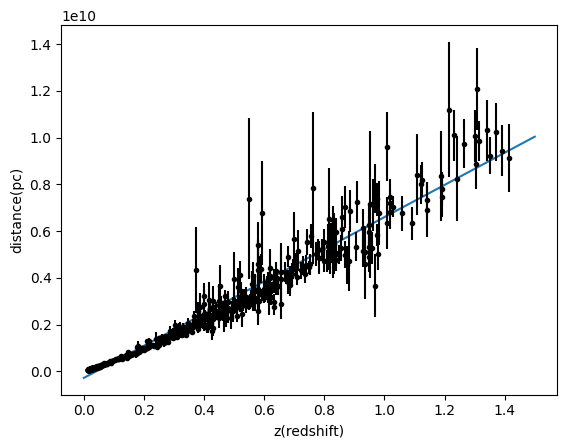

In [4]:
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy import stats

#Let's try to understand how good the fits we made in last Lesson are, let's load the supernova data again
label='data/sn_z_mu_dmu_plow_union2.1.txt'

def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

def load(iLabel,iMaxZ=10.):
    redshift=np.array([])
    distance=np.array([])
    distance_err=np.array([])
    with open(iLabel,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter='\t')
        for row in plots:
            if float(row[1]) > iMaxZ:
                continue
            redshift = np.append(redshift,float(row[1]))
            distance = np.append(distance,distanceconv(float(row[2])))
            distance_err = np.append(distance_err,distanceconverr(float(row[2]),float(row[3])))
    return redshift,distance,distance_err  
        
#Now let's run the regression again
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

redshift,distance,distance_err=load(label)
var=variance(redshift)
cov=covariance(redshift,distance)
A=cov/var
const=distance.mean()-A*redshift.mean()
xvals = np.linspace(0,1.5,100)
yvals = []
for pX in xvals:
    yvals.append(linear(pX,A,const))

plt.plot(xvals,yvals)
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.xlabel("z(redshift)")
plt.ylabel("distance(pc)")
plt.show()

<h3>Remember Numerical properties of the universe</h3>

Recall in Lecture 6 we took the following formula for the comoving distance of the redshift

$$ d(z) = \frac{c}{h_{0}}(1+z) \sum_{i=0}^{i=100} \frac{dz}{\sqrt{\Omega_{M}(1+z_{i}^{\prime})^{3} + 1-\Omega_{M}}}$$

where $dz=z/100$ and $z_{i}= dz \times i$. 

Then we went ahead and coded this up and put fit it to our supernova data. Let's run the fit and look at our previous diagnostics. 



[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 580
    # variables        = 2
    chi-square         = 539.905267
    reduced chi-square = 0.93409216
    Akaike info crit   = -37.5479587
    Bayesian info crit = -28.8219025
    R-squared          = 1.00000000
[[Variables]]
    h0:  70.4227324 +/- 0.33559027 (0.48%) (init = 70)
    Om:  0.30137175 +/- 0.01982639 (6.58%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(h0, Om) = -0.741


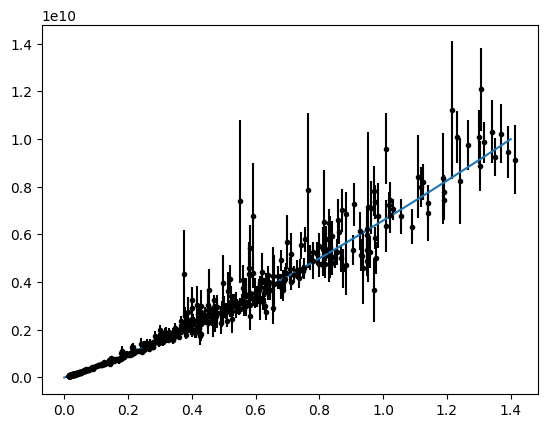

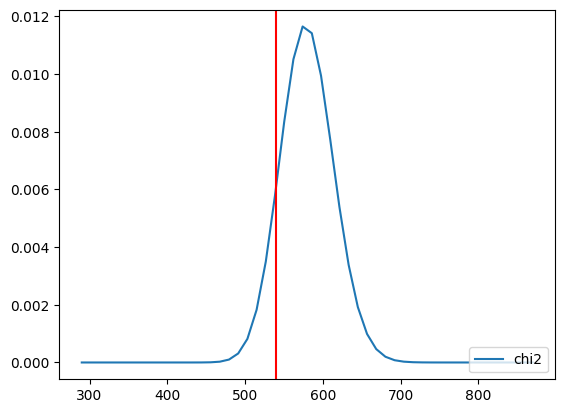

In [12]:
#>>>RUN: L6.8-runcell01
import lmfit

def hubble(z,Om):
    pVal=Om*(1+z)**3+(1.-Om)
    return np.sqrt(pVal)

def lumidistance(z,h0,Om):
    integral=0
    nint=100
    for i0 in range(nint):
        zp=z*float(i0)/100.
        dz=z/float(nint)
        pVal=1./(1e-5+hubble(zp,Om))
        integral += pVal*dz
    d=(1.+z)*integral*(1e6*3e5/h0)
    return d

model  = lmfit.Model(lumidistance)
p = model.make_params(h0=70,Om=0.2)
result = model.fit(data=distance, params=p, z=redshift, weights=1./distance_err)
lmfit.report_fit(result)

#Plot it against the data
xvals = np.linspace(0,1.4,100)
yvals = []
for pX in xvals:
    yvals.append(lumidistance(pX,result.params["h0"],result.params["Om"]))

plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.plot(xvals,yvals)
plt.show()

x = np.linspace(len(distance)*0.5,len(distance)*1.5)
chi2d=stats.chi2.pdf(x,len(distance-2)) # 40 bins
plt.plot(x,chi2d,label='chi2')
plt.axvline(result.chisqr, c='red')
plt.legend(loc='lower right')
plt.show()



Ok, the fit looks really good. Now that we have done this, lets go ahead and extend this to a 2-dimensional plot, to do the 2D plot, we now need to simulatneously scan both the two varaibles that we are fitting for, which in this is Hubble's constant $h_{0}$ and the matter density $\Omega_{m}$. 

To do this, we will run the minimizer and then we will look at the contours about the minimum. 

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_13404/570246416.py:17: RuntimeWarning: invalid value encountered in sqrt
  unc=np.sqrt(2*sol.hess_inv.matmat(np.eye(2)))


Levels: 2.295748928898636 6.180074306244173 11.829158081900795


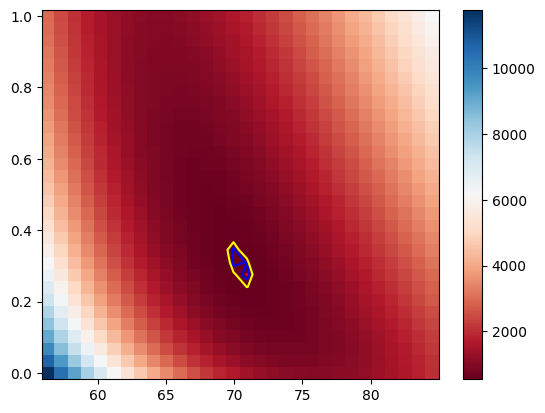

In [24]:
#Plot it against the data
def loglike(x):
    lTot=0
    for i0 in range(len(redshift)):
        xtest=lumidistance(redshift[i0],x[0],x[1])
        #lTot = lTot+(distance[i0]-xtest)**2
        lTot = lTot+((1./distance_err[i0])**2)*(distance[i0]-xtest)**2
    return lTot #*0.5 The above is 2 times loglike

#x0 = np.array([70.,0.3])
#ps = [x0]
#bnds = ((0, 1000), (0, 1.5))
#sol=opt.minimize(loglike, x0,bounds=bnds, tol=1e-6)
#sol=opt.minimize(loglike, x0,bounds=bnds)

#Finally lets get our 1D unctainies from the Hessian
unc=np.sqrt(2*sol.hess_inv.matmat(np.eye(2)))
#print("Unc matrix:",unc)
#print("h0",sol.x[0],"+/-",unc[0,0])
#print("Om:",sol.x[1],"+/-",unc[1,1])

#And lets get the correlations
#import numpy.linalg as la
#w, v=la.eig(2*sol.hess_inv)
#print("values",w,"vectors",v)
#Now lets get the correlation C(a,b) (see below)
#print("c(a,b)",v[0,1]/v[0,0])

#Now lets scan the parameters
x = np.linspace(result.params['h0']*0.9,result.params['h0']*1.1, 30)
y = np.linspace(0.,0.5, 30)
X, Y = np.meshgrid(x, y)
def pvalue(isigma):
    return stats.norm.cdf(isigma)-stats.norm.cdf(-isigma)

OneSigma   = stats.chi2.ppf(pvalue(1),2)
TwoSigma   = stats.chi2.ppf(pvalue(2),2)
ThreeSigma = stats.chi2.ppf(pvalue(3),2)
print("Levels:",OneSigma,TwoSigma,ThreeSigma)
levels = [OneSigma,TwoSigma,ThreeSigma]
for i0 in range(len(levels)):
    levels[i0] = levels[i0]+loglike([result.params['h0'],result.params['Om']])
Z = np.array([loglike([x,y]) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
fig, ax = plt.subplots(1, 1)
c = ax.pcolor(X,Y,Z,cmap='RdBu')
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
plt.show()



<h3>Fitting for the curvature</h3>


So given the Friedmann equations, we can add back the curvature term:

$$ 
d(z) = ct^{\prime} = (1+z)ct = (1+z)\frac{c}{h_{0}}\int_{0}^{z} \frac{dz^{\prime}}{\sqrt{\Omega_{M}\left(1+z^{\prime}\right)^{3} + \Omega_{\kappa}\left(1+z^{\prime}\right)^{2}+ 1-\Omega_{M}-\Omega_{\kappa}}}
$$

We dan adjust the luminosity distance to add this back. Recall that 

$$
\Omega_{m}+\Omega_{k}+\Omega_{\Lambda}=1
$$
So we only need to float two fo them. Let's go ahead and run the fit. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 580
    # variables        = 3
    chi-square         = 539.699855
    reduced chi-square = 0.93535504
    Akaike info crit   = -35.7686662
    Bayesian info crit = -22.6795819
    R-squared          = 1.00000000
[[Variables]]
    h0:   70.5560353 +/- 0.43865655 (0.62%) (init = 70)
    Om:   0.40101780 +/- 0.21086304 (52.58%) (init = 0.3)
    OmL:  0.78991346 +/- 0.19274007 (24.40%) (init = 0.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om, OmL) = 0.980
    C(h0, OmL) = 0.692
    C(h0, Om)  = 0.579


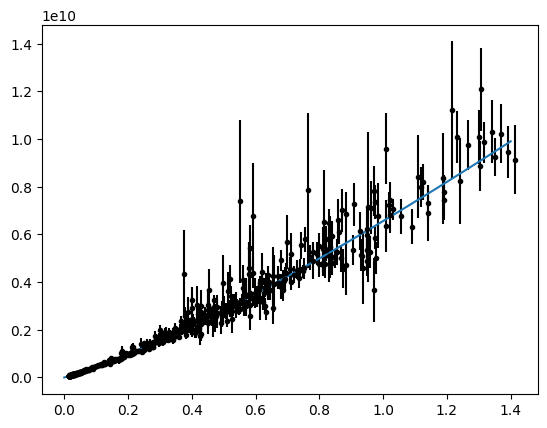

In [31]:
#And finally lets actually float both the matter and dark energy
def hubble2(z,Om,OmL):
    pVal=Om*(1+z)**3+OmL+(1-OmL-Om)*(1+z)**2
    return np.sqrt(pVal)

def lumidistance2(x,h0,Om,OmL):
    integral=0
    nint=100
    for i0 in range(nint):
        pVal=1./(1e-5+hubble2(x*float(i0)/100.,Om,OmL))
        integral += pVal*x/float(nint)
    d=(1.+x)*integral*(1e6*3e5/h0)
    return d

def loglike2(x):
    lTot=0
    for i0 in range(len(redshift)):
        xtest=lumidistance2(redshift[i0],x[0],x[1],x[2])
        #lTot = lTot+(distance[i0]-xtest)**2
        lTot = lTot+((1./distance_err[i0])**2)*(distance[i0]-xtest)**2
    return lTot #*0.5 The above is 2 times loglike


model  = lmfit.Model(lumidistance2)
p = model.make_params(h0=70,Om=0.3,OmL=0.7)
result = model.fit(data=distance, params=p, x=redshift, weights=1./distance_err)
lmfit.report_fit(result)
#plt.figure()
#result.plot()

#Plot it against the data
xvals = np.linspace(0,1.4,100)
yvals = []
for pX in xvals:
    yvals.append(lumidistance2(pX,result.params["h0"],result.params["Om"],result.params["OmL"]))

plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.plot(xvals,yvals)
plt.show()


Now lets see if we cna make our plot. We will draw the log likelihood about the best fit from lmfit, and then we will draw the contours. Also lets not go overboard on the contours

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_13404/2140690754.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(pVal)


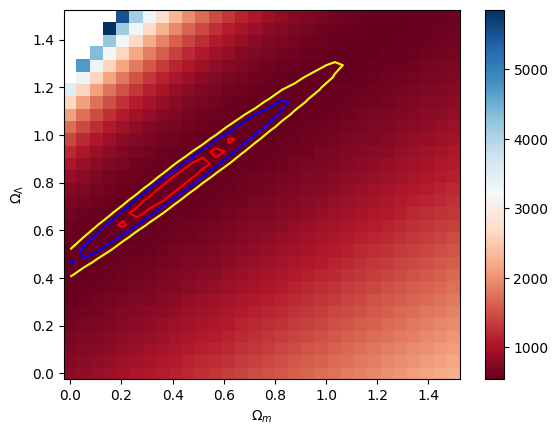

In [33]:
#result.params["a"].value,result.params["b"].value
#Now lets scan the parameters
x = np.linspace(0,1.5,30)
y = np.linspace(0,1.5,30)
X, Y = np.meshgrid(x, y)
levels = [OneSigma,TwoSigma,ThreeSigma]
for i0 in range(len(levels)):
    levels[i0] = levels[i0]+loglike2([result.params["h0"],result.params["Om"],result.params["OmL"]])
Z = np.array([loglike2([result.params["h0"],x,y]) for (x,y) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
fig, ax = plt.subplots(1, 1)
c = ax.pcolor(X,Y,Z,cmap='RdBu')
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
plt.xlabel('$\Omega_{m}$')
plt.ylabel('$\Omega_{\Lambda}$')
plt.show()

This finally gives us our 2D plot that, and you can see that it looks good

<a name='section_8_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.2 Principal Component Analysis</h2>     

| [Top](#section_8_0) | [Previous Section](#section_8_1) | [Exercises](#exercises_8_2) |


<h3>Overview</h3>

Finally, I would like to say that this method of finding the ellipse is our first deep learning method.
This procedure of computing the covariance matrix, and finding the eigenvectors is known as  principal component analysis or PCA. Let's run it on our example and look from <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html" target="_blank">Python Data Science Handbook by Jake VanderPlas</a>.

First, what we can do is look at our old correlated fit. All this will do is get the eigenvectors and values for our 2D plot.

In [ ]:
#>>>RUN: L8.4-runcell01
from sklearn.decomposition import PCA
import numpy.linalg as la
#make some toy data
lAs = np.random.normal(0,1,1000)
lBs = np.random.normal(0,1,1000)+0.5*lAs
cov = np.cov([lAs,lBs])
#eigen cov
w, v=la.eig(cov)


plt.plot(lAs,lBs,".")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X=(np.vstack([lAs,lBs])).T
pca = PCA(n_components=2)
pca.fit(X)
print("PCA vectors")
print(pca.components_)
print("PCA values")
print(pca.explained_variance_)
print("Old Eigen","vectors",w,"values",v)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',linewidth=2,shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(lAs, lBs, alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Finally, we can try this on an ML dataset. Let's take images with many pixels and treat each pixel as a separate dimension. We can then run the decomposition on the image by decomposing the n-pixel by n-pixel correlation matrix. What we will do is take an image that is 62x47=2914 Pixels. From that we can compute the covariance matrix and we can start to diagonlize this. Since this is a large matrix (2914x2914), we have to use sophisticaed eigen decomposition strategies. In this case, we will use something called RandomizedPCA. 

What we are going to do is run PCA on the images, and take the top 200 eigenvectors from that. Then we are going to plot the top few of these eigen vectors and the cumulative explained variance, which is a metric for how much information can be gained by adding dimensions. 

In [ ]:
#>>>RUN: L8.4-runcell02

#Now let's do it ML style for fun
#Load some faces of images
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Let's plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='bone')
    
#Fit them to PCA 
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(200)
pca.fit(faces.data)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Let's plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
plt.show()
    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


What you can see above is that the top eigen vectors capture the shape of the face. You can see the shape variations between the different eigenvectors as you go through. Youc an see also that about 80% of the total info in the first 200 eigenvectors is captures in the first 25 components. 

Finally, what we can do is plot our world leaders just by taking the first 80 eigenvectors of our sample. What we have effectively done is compress our original image into just 80 values, thats all!

In [ ]:
#>>>RUN: L8.4-runcell03

# Compute the components and projected faces
pca = RandomizedPCA(80).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('80-dim\nreconstruction');


<h3>Exercise using stellar spectra</h3>

As a final exercise, we are going to isolate features from stellar spectra of the Sloan Digit Sky Survey. To that, let's first load data from the SDSS and try to understand what this looks like. We will use the `astroML` package, that allows us to pull astro data quickly. 

From this data, we will look at redshift correct galaxy spectra. The correction allows us to look at the large population of galaxies in this dataset and try to find the dominant features. Let's take a quick look at the data. 

In [ ]:
#>>>RUN: L8.4-runcell04

from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']
count=-1
#let's plot this guy
fig, ax = plt.subplots(2, 10, figsize=(20, 5.5),subplot_kw={'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
nrows = 2; ncols = 10
for i in range(ncols):
    for j in range(nrows):
        count=count+1
        ax[j,i].plot(wavelengths,spectra_raw[count], '-k', lw=1)
        ax[j,i].set_xlim(3100, 7999)
        if j < nrows - 1:
            ax[j,i].xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax[j,i].set_xlabel(r'wavelength $(\AA)$')
            
plt.show()


What you see is that the spectra vary, but there are a few lines from the galaxies that are particularly bright. Look at the one above 6000 Angstroms. That the Hydrogen, $\beta$ emission line. You can see the whole table of lines <a href="http://astronomy.nmsu.edu/drewski/tableofemissionlines.html" target="_blank">here</a>.

In the following problem, we will look closely at the dominant eigenvector and identify any spectral lines that it might include.

<a name='exercises_8_4'></a>   

| [Top](#section_8_0) | [Restart Section](#section_8_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-8.4.1</span>

Your task is run PCA, look at the dominant eigenvector, and find the top two spectral lines. What do they correspond to (refer to the table <a href="http://astronomy.nmsu.edu/drewski/tableofemissionlines.html" target="_blank">here</a>.)?

Select two spectral lines from the options below (in units of angstroms):

- He ~4200
- H$\gamma$ ~4350
- H$\beta$ ~4860
- O III ~4950
- O III ~5006
- H$\alpha$ ~6560
- N II ~6580
- O I ~7000

Does this make sense?


In [ ]:
#>>>EXERCISE: L8.4.1

# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']

#select only the first 850 bins to avoid noise features
spectra_raw = spectra_raw[:,0:850]
wavelengths = wavelengths[0:850]
pca = RandomizedPCA()


#YOUR CODE HERE
#fit the pca to the spectra_raw data 
#plot the first eigenvector, pca.components_[0] over the full range of wavelengths
#optionally constrain the wavelength range to zoom in on spectral lines

In [ ]:
#>>>SOLUTION: L8.4.1

from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']
spectra_raw = spectra_raw[:,0:850]
wavelengths = wavelengths[0:850]

pca = RandomizedPCA()
pca.fit(spectra_raw)
plt.plot(wavelengths,pca.components_[0] , '-k', lw=1)
plt.xlabel(r'wavelength $(\AA)$')
#plt.xlim(6500,7000)
plt.show()


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>

- O III ~5006
- H$\alpha$ ~6560

</pre>
        
**EXPLANATION:**
    
These emissions lines are famous lines from Oxygen and Hydrogen. See for example <a href="https://en.wikipedia.org/wiki/Doubly_ionized_oxygen" target="_blank">here</a>.
    
</div>


>#### Follow-up 8.4.1a (ungraded)
>
>Plot all of the eigenvectors. What are the dominant features of each?

In [ ]:
#>>>SOLUTION: L8.4.1

#Now let's look at the top 100 eigen vectors 
count=-1
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,bottom=0.1, top=0.95, hspace=0.05)
nrows = 10; ncols = 10
for i in range(ncols):
    for j in range(nrows):
        count=count+1
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths,pca.components_[count] , '-k', lw=1)
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')
plt.show()